### Load data and visualize the important features

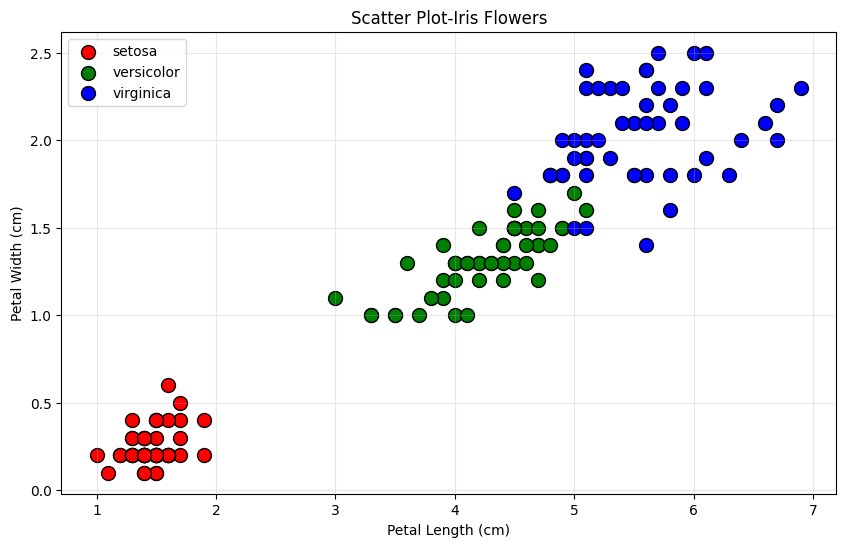

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load data (only 2 features for visualization)
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, [2, 3]]  # Petal length, Petal width)
y = iris.target

# Visualize the data FIRST
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.scatter(X[y == i, 0], X[y == i, 1], 
                color=colors[i], label=iris.target_names[i],
                edgecolor='black', s=100)
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Scatter Plot-Iris Flowers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Creating a decision tree
Creating a simple decision tree by using Gini Impurity, setting max depth as stopping criteria

In [7]:
class SimpleDecisionTree:
    """A decision tree that learns the rules automatically"""
    
    def __init__(self, max_depth=2):
        self.max_depth = max_depth
        self.rules = []  # Will store our decision rules
        
    def find_best_split(self, X, y):
        """Find the best question to ask"""
        best_gain = 0
        best_question = None
        
        # Try all possible splits
        for feature_idx in range(X.shape[1]):  # For each feature
            thresholds = np.unique(X[:, feature_idx]) # Store all unique values
            
            for threshold in thresholds:
                # Split the data
                left_mask = X[:, feature_idx] < threshold
                right_mask = ~left_mask
                
                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue
                
                # Calculate how good this split is
                gain = self.calculate_gain(y, y[left_mask], y[right_mask])
                
                if gain > best_gain:
                    best_gain = gain
                    best_question = {
                        'feature': feature_idx,
                        'threshold': threshold,
                        'gain': gain
                    }
        
        return best_question
    
    def calculate_gain(self, parent, left, right):
        """How much better is the split?"""
        # Simple purity measure
        def impurity(group):
            if len(group) == 0:
                return 0
            # Count most common class
            most_common = np.bincount(group).max() # Choosing the mode(highest occurence)
            return 1 - (most_common / len(group))
        
        parent_impurity = impurity(parent)
        n = len(parent)
        n_left, n_right = len(left), len(right)
        
        weighted_impurity = (n_left/n)*impurity(left) + (n_right/n)*impurity(right)
        
        return parent_impurity - weighted_impurity #gain = parent impurity - weighted impurity
    
    def fit(self, X, y, depth=0):
        """Learn the tree from data"""
        question = self.find_best_split(X, y)
        
        if depth >= self.max_depth or question is None:
            # Make a leaf node (predict most common class)
            self.rules.append({
                'type': 'leaf',
                'prediction': np.bincount(y).argmax()
            })
            return
        
        # Split the data
        left_mask = X[:, question['feature']] < question['threshold']
        right_mask = ~left_mask 
        
        # Store the rule
        self.rules.append({
            'type': 'split',
            'feature': question['feature'],
            'threshold': question['threshold'],
            'gain': question['gain']
        })
        
        # Recursively build left and right branches
        self.fit(X[left_mask], y[left_mask], depth + 1)
        self.fit(X[right_mask], y[right_mask], depth + 1)
    
    def predict(self, X):
        """Make predictions"""
        predictions = []
        for sample in X:
            node_idx = 0
            while True:
                rule = self.rules[node_idx]
                if rule['type'] == 'leaf':
                    predictions.append(rule['prediction'])
                    break
                else:
                    if sample[rule['feature']] < rule['threshold']:
                        node_idx += 1  # Go to left child, left child = idx+1
                    else:
                        # Skip left child, go to right child, right child = idx+2
                        node_idx += 2  
        return np.array(predictions)

print("Training our Simple Decision Tree...")
tree = SimpleDecisionTree(max_depth=2)
tree.fit(X, y)

print("Learned rules:")
for i, rule in enumerate(tree.rules):
    if rule['type'] == 'split':
        selected_idx = [2,3] #because we used only two features(petal length and petal width)
        selected_feature_names = [iris.feature_names[i] for i in selected_idx]  
        feature_name = selected_feature_names[rule['feature']]
        print(f"Rule {i}: If {feature_name} < {rule['threshold']:.2f} (gain: {rule['gain']:.3f})")
    else:
        print(f"Rule {i}: Predict {iris.target_names[rule['prediction']]}")

# Test accuracy
predictions = tree.predict(X)
accuracy = np.mean(predictions == y)
print(f"\n✅ Accuracy: {accuracy:.1%}")

Training our Simple Decision Tree...
Learned rules:
Rule 0: If petal length (cm) < 3.00 (gain: 0.333)
Rule 1: Predict setosa
Rule 2: If petal width (cm) < 1.70 (gain: 0.440)
Rule 3: Predict versicolor
Rule 4: Predict virginica

✅ Accuracy: 96.0%


### Plotting scatter plot of same sample with decision tree boundaries

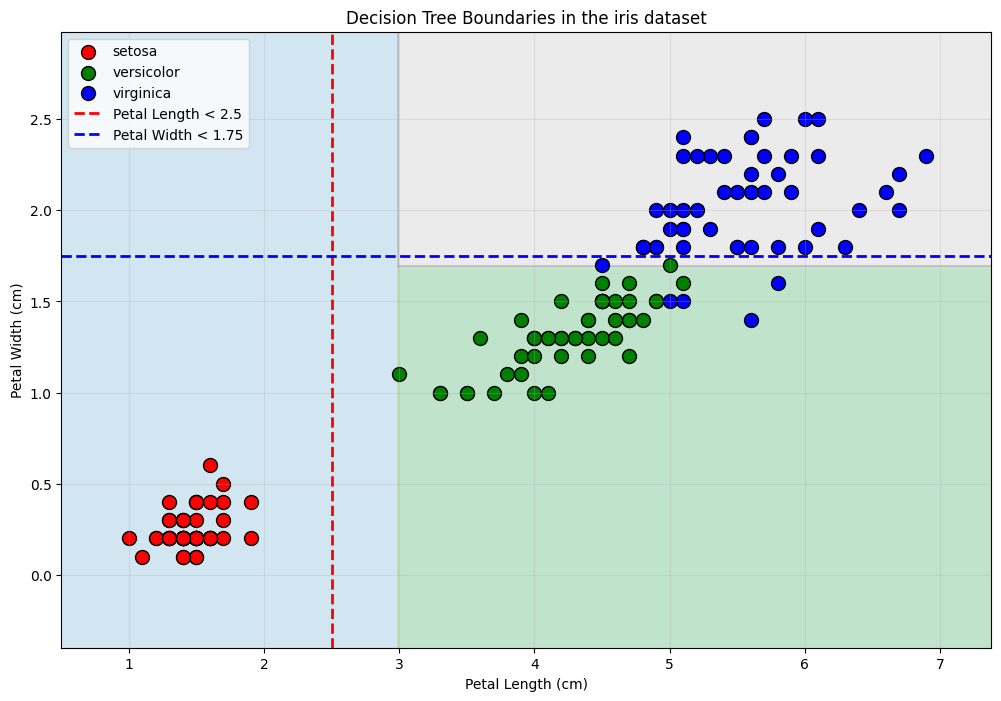

In [9]:
# Create a mesh grid to see decision boundaries
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict for each point in the mesh
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab20c')
for i in range(3):
    plt.scatter(X[y == i, 0], X[y == i, 1], 
                color=colors[i], label=iris.target_names[i],
                edgecolor='black', s=100)

# Draw the decision boundaries (simplified)
plt.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='Petal Length < 2.5')
plt.axhline(y=1.75, color='blue', linestyle='--', linewidth=2, label='Petal Width < 1.75')

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Decision Tree Boundaries in the iris dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()